In [155]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

In [156]:
data = read_csv('data/agg/BTC_agg_OI_FR.csv', parse_dates=['timestamp'])
data = data.set_index('timestamp')
data

,Agg Weighted FR,Agg OI
timestamp,,
2020-04-01,-0.039073,6.966046e+08
2020-04-02,0.006521,6.665020e+08
2020-04-03,-0.021530,6.837366e+08
2020-04-04,-0.008062,6.865173e+08
2020-04-05,0.001697,6.757367e+08
...,...,...
2023-12-27,0.029520,3.147515e+09
2023-12-28,0.030703,3.135693e+09
2023-12-29,0.019693,3.065951e+09


In [157]:
data.describe()

,Agg Weighted FR,Agg OI
count,1370.000000,1.370000e+03
mean,0.009265,2.191727e+09
std,0.027423,1.025668e+09
min,-0.122913,6.665020e+08
25%,-0.000202,1.555388e+09
50%,0.005882,1.914305e+09
75%,0.009984,2.480431e+09
max,0.242442,6.955728e+09


Quantile_25: Mean = -0.05584171825000093, Std = 0.003374051073522608, Skew = 0.973966685231782


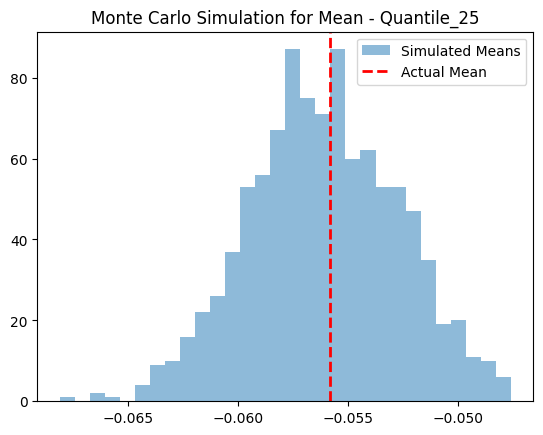

Quantile_50: Mean = -0.044826200341419147, Std = 0.0046529100225651985, Skew = -1.0867023949478414


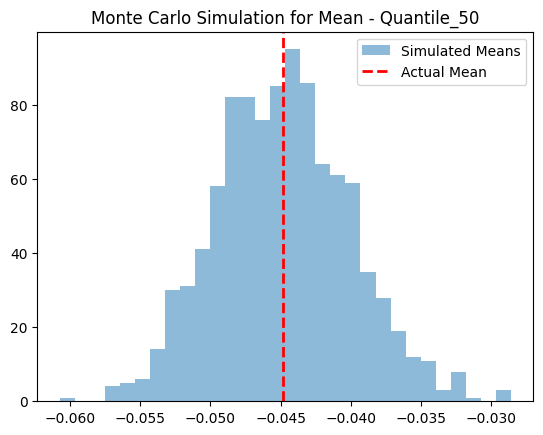

Quantile_75: Mean = -0.038432216849635964, Std = 0.0005892959643794105, Skew = -0.8835005596262147


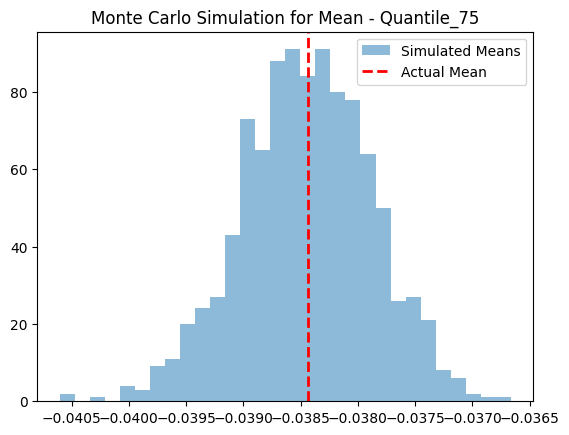

Quantile_95: Mean = 0.010029230014168358, Std = 0.026324996024906157, Skew = 4.042646248106128


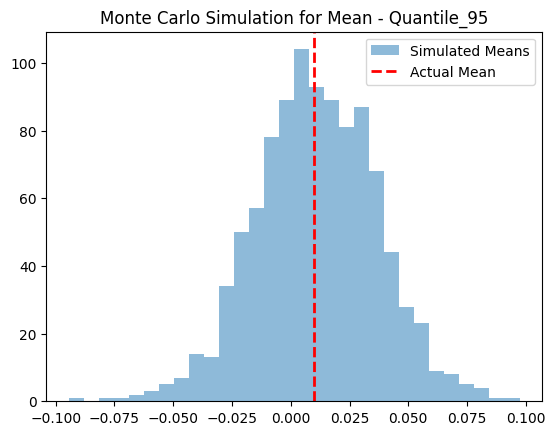

In [158]:
quantiles = [0.25, 0.50, 0.75, 0.95]
quantile_values = np.percentile(data['Agg Weighted FR'], quantiles)

quantile_dfs = {}

simulated_dfs = {}


for i in range(len(quantiles)):
    if i < len(quantiles) - 1:
        quantile_df = data[(data['Agg Weighted FR'] >= quantile_values[i]) & (data['Agg Weighted FR'] < quantile_values[i+1])]
    else:
        quantile_df = data[data['Agg Weighted FR'] >= quantile_values[i]]

    quantile_dfs[f'Quantile_{int(quantiles[i]*100)}'] = quantile_df
    simulated_dfs[f'Quantile_{int(quantiles[i]*100)}'] = data.copy()

    mean_value = quantile_dfs[f'Quantile_{int(quantiles[i]*100)}']['Agg Weighted FR'].mean()
    std_value = quantile_dfs[f'Quantile_{int(quantiles[i]*100)}']['Agg Weighted FR'].std()

    num_simulations = 1000
    simulated_means = np.random.normal(mean_value, std_value, num_simulations)
    simulated_dfs[f'Quantile_{int(quantiles[i]*100)}']['Agg Weighted FR Simulated'] = np.random.choice(simulated_means, len(data))


for name, quantile_df in quantile_dfs.items():
    mean_value = quantile_df['Agg Weighted FR'].mean()
    std_value = quantile_df['Agg Weighted FR'].std()
    skew_value = quantile_df['Agg Weighted FR'].skew()

    print(f"{name}: Mean = {mean_value}, Std = {std_value}, Skew = {skew_value}")

    num_simulations = 1000
    simulated_means = np.random.normal(mean_value, std_value, num_simulations)

    plt.hist(simulated_means, bins=30, alpha=0.5, label='Simulated Means')
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Actual Mean')
    plt.title(f'Monte Carlo Simulation for Mean - {name}')
    plt.legend()
    plt.show()

In [159]:
mean_value = data['Agg Weighted FR'].mean()
std_value = data['Agg Weighted FR'].std()

num_simulations = 1000
simulated_means = np.random.normal(mean_value, std_value, num_simulations)

simulated_dfs['default'] = data.copy()
simulated_dfs['default']['Agg Weighted FR Simulated'] = np.random.choice(simulated_means, len(data))

origin_mean_value = data['Agg Weighted FR'].mean()
origin_std_value = data['Agg Weighted FR'].std()
print(f"Origin Mean = {origin_mean_value}, Origin Std = {origin_std_value}")

simulated_mean_value = simulated_dfs['default']['Agg Weighted FR Simulated'].mean()
simulated_std_value = simulated_dfs['default']['Agg Weighted FR Simulated'].std()
print(f"Simulated Mean = {simulated_mean_value}, Simulated Std = {simulated_std_value}")


Origin Mean = 0.009265286379689128, Origin Std = 0.02742312262004318
Simulated Mean = 0.008156291232528345, Simulated Std = 0.02743455488388329


In [160]:
def get_fund_data_scenario_1(df_name):
    fund_data = data.copy()

    fund_data['Pos Size 1'] = fund_data['Agg OI'] * 5e-2
    fund_data['Pos Size 2'] = fund_data['Agg OI'] * 1e-1

    fund_data['Return 1'] = fund_data[f'Pos Size 1'] * fund_data['Agg Weighted FR']
    fund_data['Return 2'] = fund_data[f'Pos Size 2'] * fund_data['Agg Weighted FR']

    fund_data['Return 1 Simulated'] = fund_data[f'Pos Size 1'] * simulated_dfs[df_name]['Agg Weighted FR Simulated']
    fund_data['Return 2 Simulated'] = fund_data[f'Pos Size 2'] * simulated_dfs[df_name]['Agg Weighted FR Simulated']

    return fund_data

In [161]:
def get_fund_data_scenario_2(tvl):
    fund_data = data.copy()

    fund_data['Pos Size'] = tvl

    fund_data['Return'] = fund_data[f'Pos Size'] * fund_data['Agg Weighted FR']

    return fund_data

In [162]:
fund_data = get_fund_data_scenario_1('default')

In [163]:
def calculate_profit(data, pos, kr, fee, sim=False):
    '''
    args:
        pos - position size: 1 or 2
        kr - keep rate: 0.1, 0.2 or 0.5
        fee - fee value in percent
    '''
    fees = kr * data[f'Pos Size {pos}'] * fee / 1e2
    return data[f'Return {pos}'] - fees if not sim else data[f'Return {pos} Simulated'] - fees

In [164]:
origin_profit = calculate_profit(fund_data, 1, 0.1, 0.06)

In [165]:
origin_profit.sum()

2330098531.161789

In [166]:
origin_profit.mean()

1700801.8475633496

<AxesSubplot: xlabel='timestamp'>

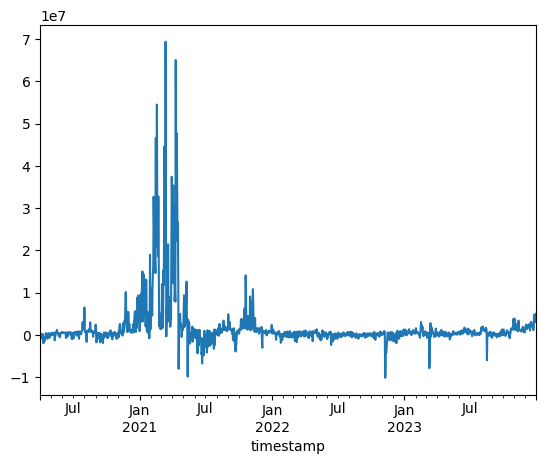

In [167]:
origin_profit.plot()

In [168]:
simulated_profit = calculate_profit(fund_data, 1, 0.1, 0.06, True)

In [169]:
simulated_profit.sum()

1152944276.3621955

In [170]:
simulated_profit.mean()

841565.1652278799

<AxesSubplot: xlabel='timestamp'>

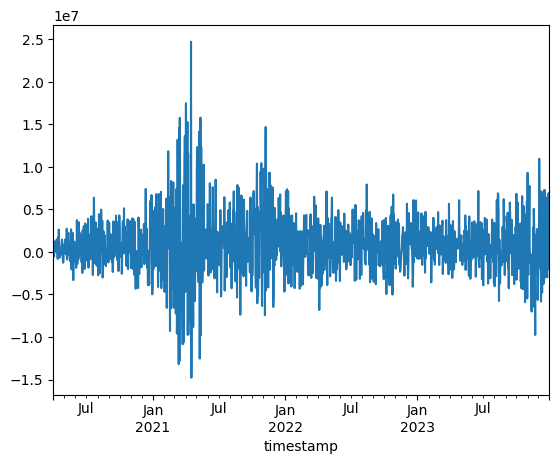

In [171]:
simulated_profit.plot()

fund dynamic at Quantile 25

In [172]:
fund_data_25 = get_fund_data_scenario_1('Quantile_25')

In [173]:
simulated_25_profit = calculate_profit(fund_data_25, 1, 0.1, 0.06, True)

<AxesSubplot: xlabel='timestamp'>

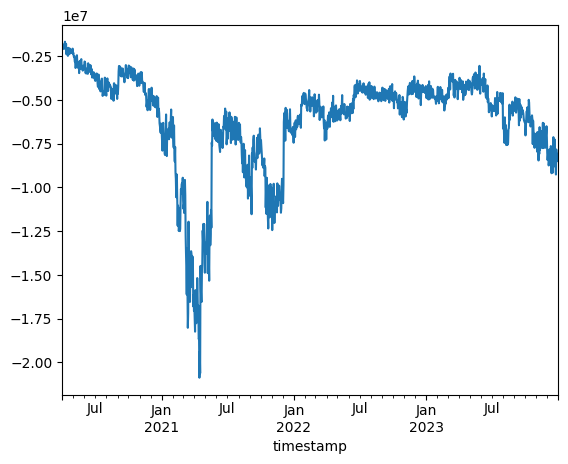

In [174]:
simulated_25_profit.plot()

In [175]:
start_at = fund_data_25['Pos Size 1'][0]

days_till_zero = 0
for pnl in simulated_25_profit:
    start_at += pnl
    days_till_zero += 1
    if start_at <= 0:
        break

days_till_zero

18

fund dynamic at Quantile 50

In [176]:
fund_data_50 = get_fund_data_scenario_1('Quantile_50')

In [177]:
simulated_50_profit = calculate_profit(fund_data_50, 1, 0.1, 0.06, True)

<AxesSubplot: xlabel='timestamp'>

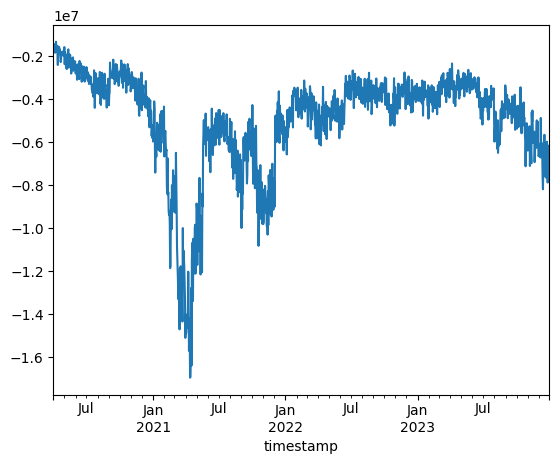

In [178]:
simulated_50_profit.plot()

In [179]:
start_at = fund_data_50['Pos Size 1'][0]

days_till_zero = 0
for pnl in simulated_50_profit:
    start_at += pnl
    days_till_zero += 1
    if start_at <= 0:
        break

days_till_zero

21

fund dynamic at historically worst FR

In [180]:
fr_quarterly = data.copy()

fr_quarterly = fr_quarterly.resample('Q').mean()

In [181]:
min(fr_quarterly['Agg Weighted FR'])

-0.004615758642565798

In [182]:
fr_quarterly[fr_quarterly['Agg Weighted FR'] == min(fr_quarterly['Agg Weighted FR'])]

,Agg Weighted FR,Agg OI
timestamp,,
2022-12-31,-0.004616,1.706881e+09


In [183]:
fund_data_worst = data.copy().iloc[913:1005]

fund_data_worst['Pos Size'] = fund_data_worst['Agg OI'] * 5e-2

fund_data_worst['Return'] = fund_data_worst['Pos Size'] * fund_data['Agg Weighted FR']

fees = 0.1 * fund_data_worst[f'Pos Size'] * 0.06 / 1e2
fund_data_worst['Profit'] = fund_data_worst['Return'] - fees

<AxesSubplot: xlabel='timestamp'>

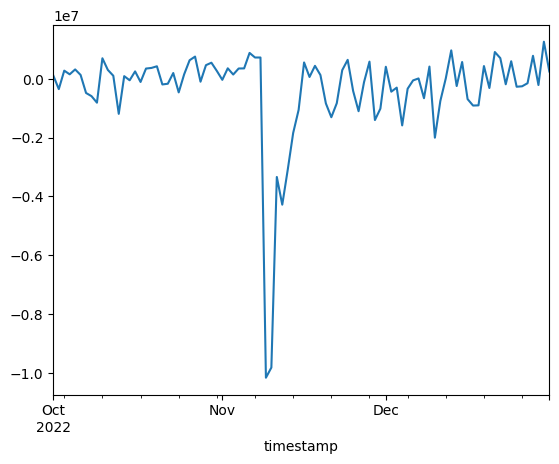

In [184]:
fund_data_worst['Profit'].plot()

In [185]:
start_at = fund_data_worst['Pos Size'][0]

days_till_zero = 0
for pnl in fund_data_worst['Profit']:
    start_at += pnl
    days_till_zero += 1
    if start_at <= 0:
        break

days_till_zero

92

In [186]:
len(fund_data_worst)

92

In [187]:
# passing through the historically worst quarter

insurance fund estimation with pos size as tvl

In [188]:
slope = 0.1485
initial_supply = 5e5

In [189]:
import numpy as np
import matplotlib.pyplot as plt

def linear_model(x, scale):
    values = initial_supply + scale * slope * x
    return np.where(values < 1e9, values, 1e9)

def exponential_model(x, scale):
    values = initial_supply * np.exp(slope * scale * x)
    return np.where(values < 1e9, values, 1e9)

def slow_exponential_model(x, scale):
    values = initial_supply * np.exp(0.074 * scale * x)
    return np.where(values < 1e9, values, 1e9)

linear_supply = linear_model(np.arange(0, 1370, 1), 1e7)
exponential_supply = exponential_model(np.arange(0, 1370, 1), 1)
slow_exponential_supply = slow_exponential_model(np.arange(0, 1370, 1), 1)

In [190]:
fund_linear = get_fund_data_scenario_2(linear_supply)
fund_exponentail = get_fund_data_scenario_2(exponential_supply)
fund_slow_exponentail = get_fund_data_scenario_2(slow_exponential_supply)

In [191]:
def calculate_profit_tvl(data, kr, fee):
    fees = kr * data[f'Pos Size'] * fee / 1e2
    return data[f'Return'] - fees

In [192]:
linear_profit = calculate_profit_tvl(fund_linear, 0.1, 0.06)
exponentail_profit = calculate_profit_tvl(fund_exponentail, 0.1, 0.06)
slow_exponentail_profit = calculate_profit_tvl(fund_slow_exponentail, 0.1, 0.06)

<AxesSubplot: xlabel='timestamp'>

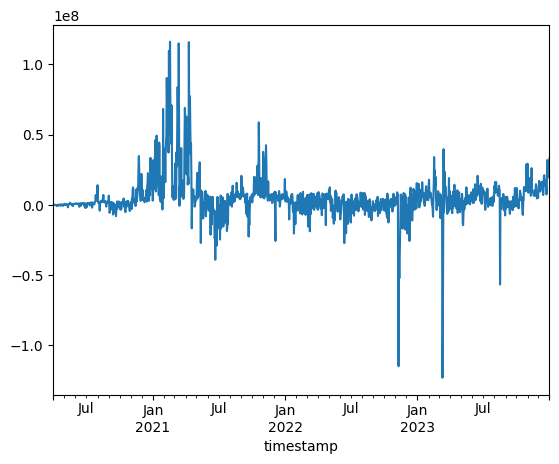

In [193]:
linear_profit.plot()

<AxesSubplot: xlabel='timestamp'>

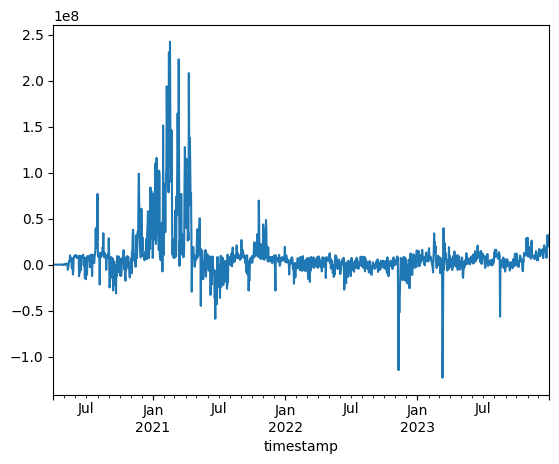

In [194]:
exponentail_profit.plot()

<AxesSubplot: xlabel='timestamp'>

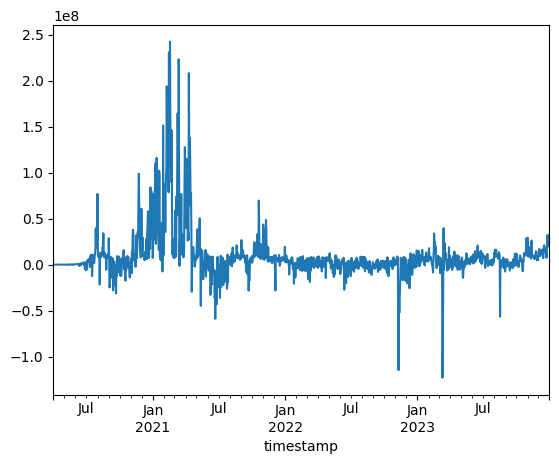

In [195]:
slow_exponentail_profit.plot()

In [196]:
linear_dynamic = [initial_supply]
exponential_dynamic = [initial_supply]
slow_exponential_dynamic = [initial_supply]

for i in range(1, len(linear_profit)):
    linear_dynamic.append(linear_dynamic[i - 1] + linear_profit[i])
    exponential_dynamic.append(exponential_dynamic[i - 1] + exponentail_profit[i])
    slow_exponential_dynamic.append(slow_exponential_dynamic[i - 1] + slow_exponentail_profit[i])

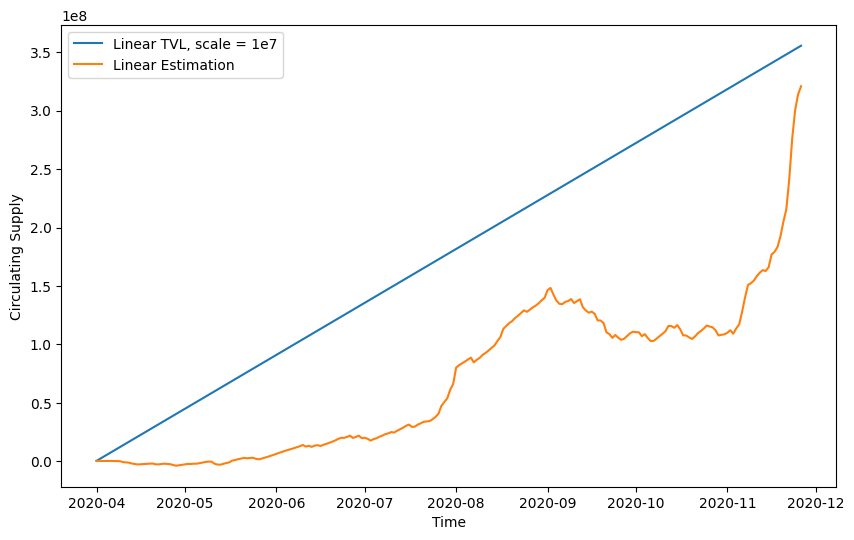

In [197]:
days_to_show = 240

plt.figure(figsize=(10, 6))

plt.plot(data.index[:days_to_show], linear_supply[:days_to_show], label='Linear TVL, scale = 1e7')
plt.plot(data.index[:days_to_show], linear_dynamic[:days_to_show], label='Linear Estimation')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Circulating Supply')
plt.show()

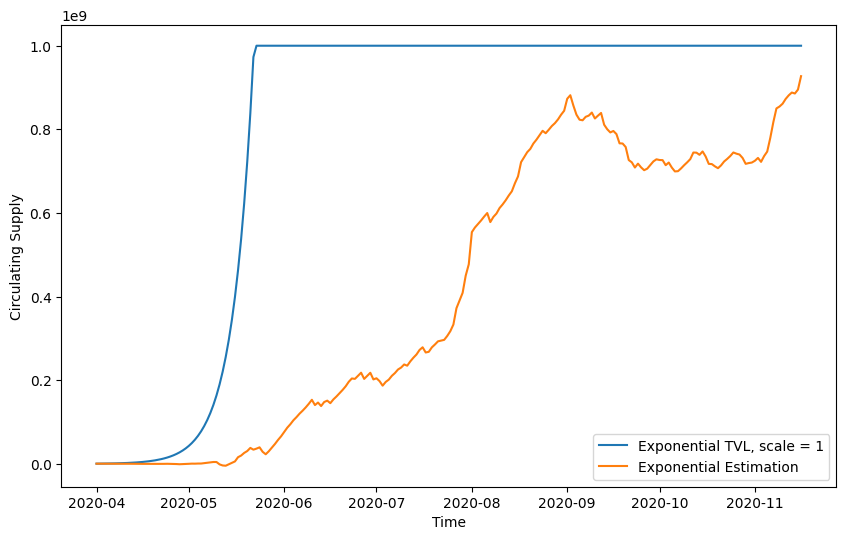

In [198]:
days_to_show = 230

plt.figure(figsize=(10, 6))

plt.plot(data.index[:days_to_show], exponential_supply[:days_to_show], label='Exponential TVL, scale = 1')
plt.plot(data.index[:days_to_show], exponential_dynamic[:days_to_show], label='Exponential Estimation')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Circulating Supply')
plt.show()

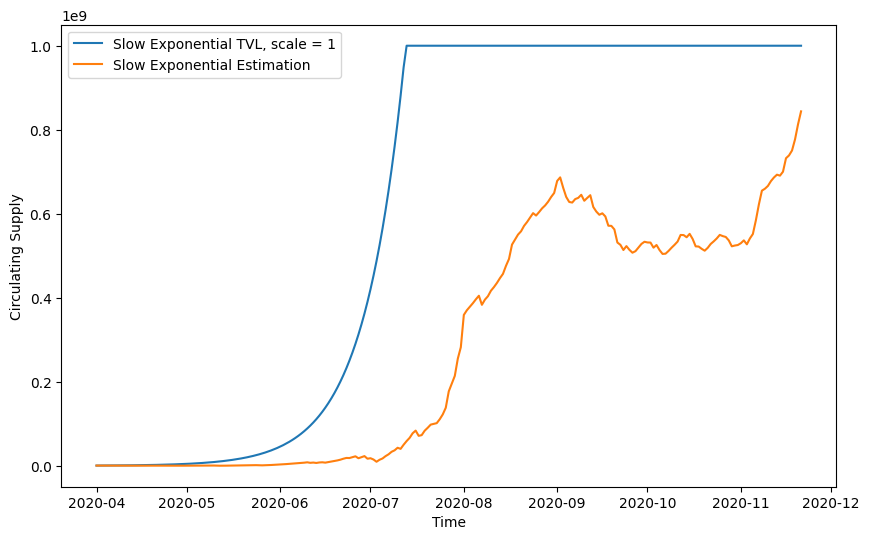

In [199]:
days_to_show = 235

plt.figure(figsize=(10, 6))

plt.plot(data.index[:days_to_show], slow_exponential_supply[:days_to_show], label='Slow Exponential TVL, scale = 1')
plt.plot(data.index[:days_to_show], slow_exponential_dynamic[:days_to_show], label='Slow Exponential Estimation')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Circulating Supply')
plt.show()